##     Feature engineering for insider threat detection
   ### first we have to create insightfull and informative feattures.
   ### As deep learning wont help as in that aspect

In [1]:
import numpy as np
import pandas as pd
dataset_path = "./r42/"

In [2]:
#reading from specific columns in the dataset
log_types_data = ["device", "email", "file", "logon", "http"]
log_fields_list = [
 ["date", "user", "activity"],
 ["date", "user", "to", "cc", "bcc"],
 ["date", "user", "filename"],
 ["date", "user", "activity"],
 ["date", "user", "url"],
]

In [5]:
#engineering various feautures and encoding them by creating a dictionary attack
new_features = 0
new_feature_map = {}

def create_new_feature(name):
    """New feature add-ons onto dictionary for encoding"""
    if name not in new_feature_map:
        global new_features
        new_feature_map[name] = new_features
        new_features += 1

In [7]:
# the newly features will be added using  our dictionary
create_new_feature("Weekday_Logon_Normal")
create_new_feature("Weekday_Logon_After")
create_new_feature("Weekend_Logon")
create_new_feature("Logoff")

create_new_feature("Connect_Normal")
create_new_feature("Connect_After")
create_new_feature("Connect_Weekend")
create_new_feature("Disconnect")

create_new_feature("Email_In")
create_new_feature("Email_Out")

create_new_feature("File_exe")
create_new_feature("File_jpg")
create_new_feature("File_zip")
create_new_feature("File_txt")
create_new_feature("File_doc")
create_new_feature("File_pdf")
create_new_feature("File_other")

create_new_feature("url")

In [9]:
#declaring a function that alerts of a file type copied to a removable media
def employee_file_features(row):
    if row["filename"].endswith(".exe"):
        return new_feature_map["File_exe"]
    if row["filename"].endswith(".jpg"):
        return new_feature_map["File_jpg"]
    if row["filename"].endswith(".zip"):
        return new_feature_map["File_zip"]
    if row["filename"].endswith(".txt"):
        return new_feature_map["File_txt"]
    if row["filename"].endswith(".doc"):
        return new_feature_map["File_doc"]
    if row["filename"].endswith(".pdf"):
        return new_feature_map["File_pdf"]
    else:
        return new_feature_map["File_other"]


In [11]:
#declaring a function to detect employess sending emails ouside the company scope
def employee_email_features(row):
    outsider = False
    if not pd.isnull(row["to"]):
        for address in row["to"].split(";"):
            if not address.endswith("dtaa.com"):
                outsider = True
                
    if not pd.isnull(row["cc"]):
        for address in row["cc"].split(";"):
            if not address.endswith("dtaa.com"):
                outsider = True
                
    if not pd.isnull(row["bcc"]):
        for address in row["bcc"].split(";"):
            if not address.endswith("dtaa.com"):
                outsider = True
                
    if outsider:
        return new_feature_map["Email_Out"]
    else:
        return new_feature_map["Email_In"]

In [13]:
#declaring a function to detect whether employee used removable media
## during non-working(Business) hours
def employee_device_features(row):
    if row["activity"] == "Connect":
        if row["date"].weekday() < 5:
            if row["date"].hour >= 8 and row["date"].hour < 17:
                return new_feature_map["Connect_Normal"]
            else:
                return new_feature_map["Connect_After"]
        else:
            return new_feature_map["Connect_Weekend"]
    else:
        return new_feature_map["Disconnect"]

In [15]:
#declaring a function to detect whether employee logged onto company Pc's
#outside non-working(business) hours
def employee_logon_features(row):
    if row["activity"] == "Logon":
        if row["date"].weekday() < 5:
            if row["date"].hour >= 8 and row["date"].hour < 17:
                return new_feature_map["Weekday_Logon_Normal"]
            else:
                return new_feature_map["Weekday_Logon_After"]
        else:
            return new_feature_map["Weekend_Logon"]
    else:
        return new_feature_map["Logoff"]

In [17]:
#declaring a function to track employee visited URL's (avoid sensitive data)
def employee_http_features(row):
    return new_feature_map["url"]

In [19]:
#declaring a function to extract timestamp of employee activity(only attack day)
def date_to_day(row):
    attack_day_only = row["date"].date()
    return attack_day_only

In [21]:
#Now we can loop through the dataset containing logs and read newly created
# employee features  into pandas data frame
employee_log_feature_functions = [
    employee_device_features,
    employee_email_features,
    employee_file_features,
    employee_logon_features,
    employee_http_features,
]

In [23]:
#we need to convert the data data to timestamp accessible by pandas
dfs = []
for i in range(len(log_types_data)):
    employee_log_type = log_types_data[i]
    employee_log_fields = log_fields_list[i]
    employee_log_feature_function = employee_log_feature_functions[i]
    df = pd.read_csv(dataset_path + employee_log_type + ".csv", usecols=employee_log_fields,index_col=None)

    date_format = "%m/%d/%Y %H:%M:%S"
    df["date"] = pd.to_datetime(df["date"], format=date_format)
    #Declearing the creation of the new feature defined above
    #Droping all features except user,date, and our new feature
    new_employee_feature = df.apply(employee_log_feature_function, axis=1)
    df["feature"] = new_employee_feature

    keep_cols = ["date", "user", "feature"]
    df = df[keep_cols]
    
    #date conversion to just a day(attack day)
    df["date"] = df.apply(date_to_day, axis=1)
    
    dfs.append(df)

In [24]:
joint = pd.concat(dfs)

In [25]:
joint = joint.sort_values(by="date")

In [26]:
joint

,date,user,feature
0,2010-01-02,MOH0273,6
1265,2010-01-02,JDC0030,17
1264,2010-01-02,AHC0142,17
1263,2010-01-02,IAR0694,17
1262,2010-01-02,AHC0142,17
...,...,...,...
854858,2011-05-17,BJM0111,3
854852,2011-05-17,BJM0111,1
854851,2011-05-17,MLM0950,1
854853,2011-05-17,JDF0593,1


### since the insider threat dataset was massive we had to trim it down into three parts(features) which would be important for the model training.

## Employing anomaly detection for insider threats Using                               the trimmed dataset

In [33]:
#potential threat employees preparation
potential_threats = [
    "AAM0658",
    "AJR0932",
    "BDV0168",
    "BIH0745",
    "BLS0678",
    "BTL0226",
    "CAH0936",
    "DCH0843",
    "EHB0824",
    "EHD0584",
    "FMG0527",
    "FTM0406",
    "GHL0460",
    "HJB0742",
    "JMB0308",
    "JRG0207",
    "KLH0596",
    "KPC0073",
    "LJR0523",
    "LQC0479",
    "MAR0955",
    "MAS0025",
    "MCF0600",
    "MYD0978",
    "PPF0435",
    "RAB0589",
    "RGG0064",
    "RKD0604",
    "TAP0551",
    "WDD0366",
    "AAF0535",
    "ABC0174",
    "AKR0057",
    "CCL0068",
    "CEJ0109",
    "CQW0652",
    "DIB0285",
    "DRR0162",
    "EDB0714",
    "EGD0132",
    "FSC0601",
    "HBO0413",
    "HXL0968",
    "IJM0776",
    "IKR0401",
    "IUB0565",
    "JJM0203",
    "KRL0501",
    "LCC0819",
    "MDH0580",
    "MOS0047",
    "NWT0098",
    "PNL0301",
    "PSF0133",
    "RAR0725",
    "RHL0992",
    "RMW0542",
    "TNM0961",
    "VSS0154",
    "XHW0498",
    "BBS0039",
    "BSS0369",
    "CCA0046",
    "CSC0217",
    "GTD0219",
    "JGT0221",
    "JLM0364",
    "JTM0223",
    "MPM0220",
    "MSO0222",
]

In [35]:
#indexing of dates as timestamps countes in insider attacks(based on dataset SD)
start_date = joint["date"].iloc[0]
end_date = joint["date"].iloc[-1]
time_horizon = (end_date - start_date).days + 1


def indexed_date(date):
    return (date - start_date).days

In [37]:
#declaring a function for the exact time series for a specific employee
def extract_employee_time_series(employee_name, df):
    return df[df["user"] == employee_name]

#vectorizing employess time-series info.. to fit in the model
def vectorize_employee_time_series(employee_name, df):
    employee_time_series = extract_employee_time_series(employee_name, df)
    x = np.zeros((len(new_feature_map), time_horizon))
    event_date_indices = employee_time_series["date"].apply(indexed_date).to_numpy()
    event_features = employee_time_series["feature"].to_numpy()
    for i in range(len(event_date_indices)):
        x[event_features[i], event_date_indices[i]] += 1
    return x

In [39]:
#declaring function for all employees' features in a vectorized time-series style
def dataset_vectorization(df):
    #featurizing the dataset
    employees = set(df["user"].values)
    X = np.zeros((len(employees), len(new_feature_map), time_horizon))
    y = np.zeros((len(employees)))
    for index, employee in enumerate(employees):
        x = vectorize_employee_time_series(employee, df)
        X[index, :, :] = x
        y[index] = int(employee in potential_threats)
    return X, y

In [41]:
X, y = dataset_vectorization(joint)

In [42]:
#Now we can start training and testing our model by splitting it first
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [45]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(750, 18, 501)
(750,)
(250, 18, 501)
(250,)


In [47]:
#reshaping vectorized data
X_train_reshaped = X_train.reshape([X_train.shape[0], X_train.shape[1] * X_train.shape[2]])
X_test_reshaped = X_test.reshape([X_test.shape[0], X_test.shape[1] * X_test.shape[2]])

In [49]:
#now we plit the traingin & testing dataset into threat and non-threats
# 0's = normal & 1's = threats
X_train_normal = X_train_reshaped[y_train == 0, :]
print(X_train_normal.shape)

X_train_threat = X_train_reshaped[y_train == 1, :]
print(X_train_threat.shape)

X_test_normal = X_test_reshaped[y_test == 0, :]
print(X_test_normal.shape)

X_test_threat = X_test_reshaped[y_test == 1, :]
print(X_test_threat.shape)

(697, 9018)
(53, 9018)
(233, 9018)
(17, 9018)


In [51]:
#Finally we can now implement the isolation-forest model
from sklearn.ensemble import IsolationForest

contamination_parameter = 0.035
isolation_train = IsolationForest( n_estimators=100, max_samples=256, contamination=contamination_parameter)

In [53]:
#Time to fit I.F classifier into the training data
isolation_train.fit(X_train_reshaped)

IsolationForest(contamination=0.035, max_samples=256)

In [57]:
#saving the model
import pickle
pickle.dump(isolation_train, open('ITD_model.pkl', 'wb'))

In [59]:
#testing savevd model
isolation_train = pickle.load(open('ITD_model.pkl', 'rb'))
print(isolation_train.decision_function(X_train_normal))

[ 2.11966073e-01  1.98443562e-01  2.18687445e-01  2.29119175e-01
  2.15892796e-01  2.29615633e-01  2.27031101e-01  6.57571426e-02
  1.16758177e-01  2.13094060e-01  2.16201010e-01  1.98752592e-01
  2.29268496e-01  2.28517046e-01  8.91562489e-02  6.99509388e-02
  2.25785356e-01  2.18973997e-01  2.03528681e-01  1.78854096e-01
  2.25144973e-01  2.26640094e-01 -3.39648997e-02  2.24905320e-01
  1.88744229e-01  2.22626832e-01  2.19695951e-01  1.18609180e-01
  2.30152525e-01  2.30421386e-01  2.26009651e-01 -8.81581710e-03
  1.31760743e-01  1.73731901e-01  2.30059465e-01  1.08791956e-01
  1.46068002e-01  1.33712744e-01  2.12187693e-01  2.18449853e-01
  2.30616651e-01  7.03546706e-02  2.10919632e-01  2.30554601e-01
  1.93582947e-01  2.25943683e-01  2.15320031e-01 -6.82410371e-02
  2.18372446e-01  2.31842940e-01  2.04505664e-01  2.22996244e-01
  2.25970518e-01  2.25638918e-01  2.18026901e-02  2.27107628e-01
  2.28939150e-01  2.21911798e-01 -6.60004802e-02  1.16229176e-01
  2.30969720e-01  2.28191

Text(0.5, 1.0, 'Distribution of Insider threat score for non-threat employees')

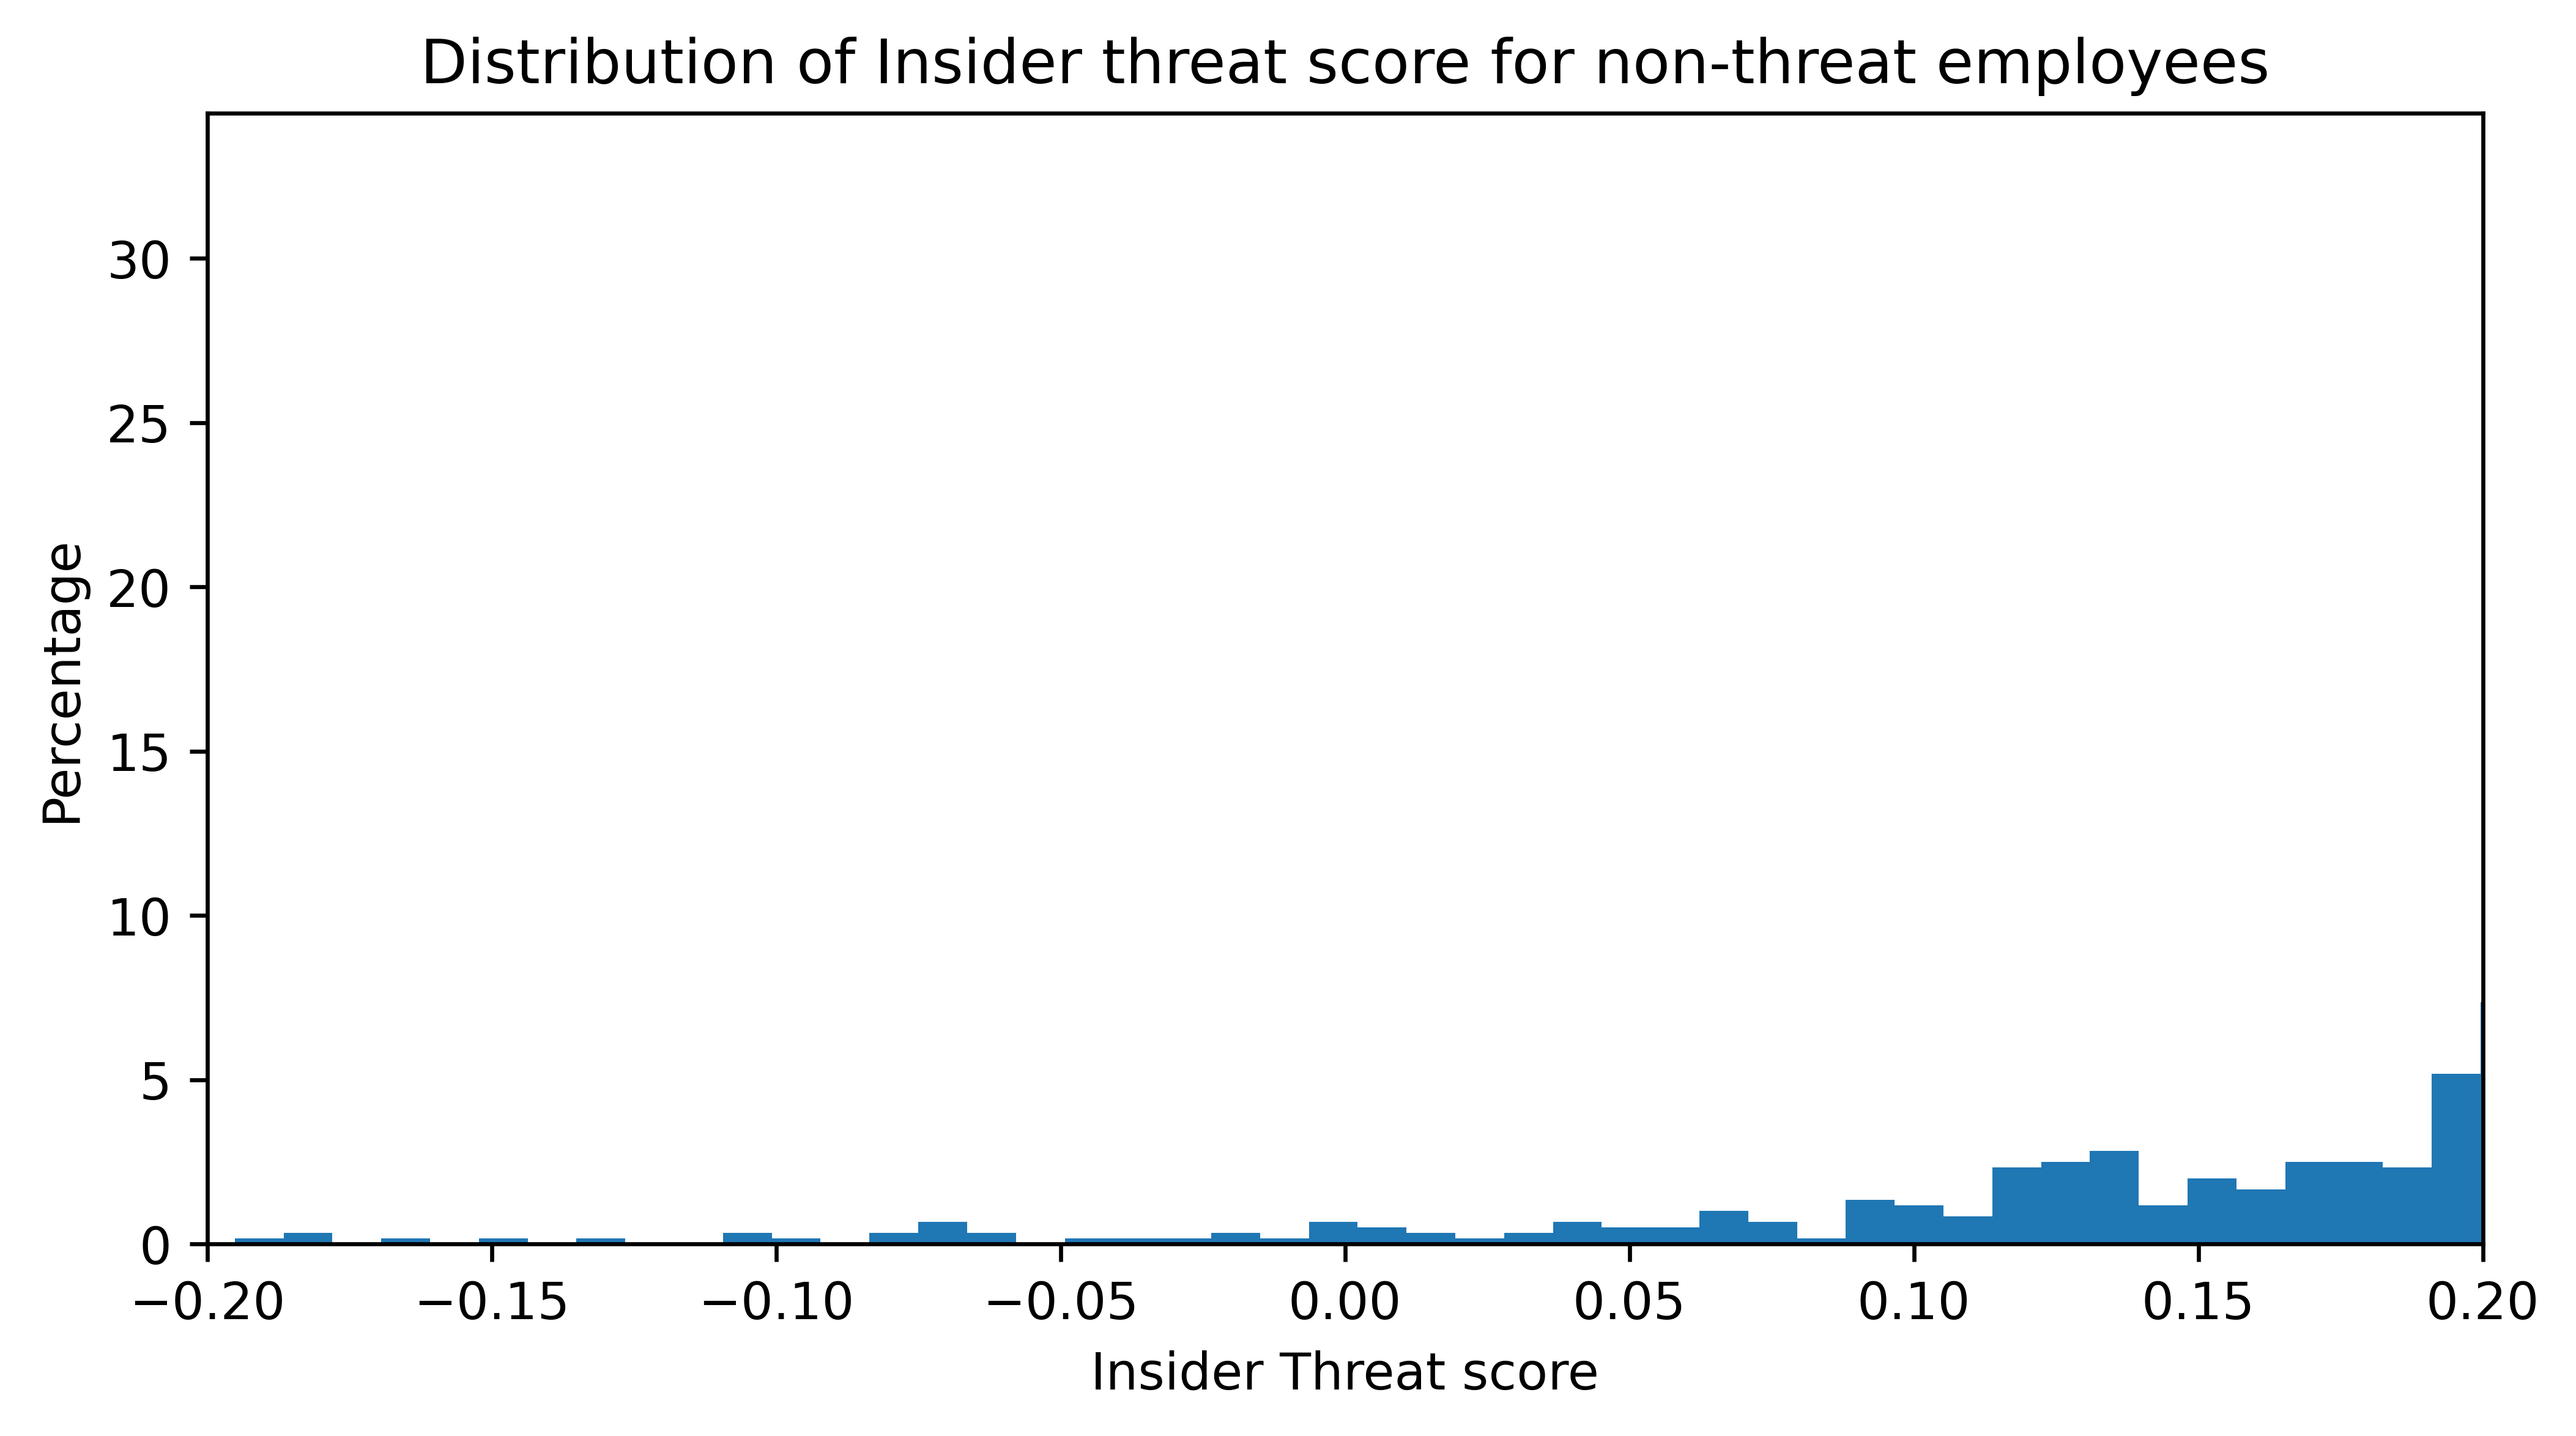

In [61]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

#Plotting for normal employee behaviours (score)
normal_scores = isolation_train.decision_function(X_train_normal)

fig = plt.figure(figsize=(8, 4), dpi=600, facecolor="w", edgecolor="k")
normal = plt.hist(normal_scores, 50, density=True)

plt.xlim((-0.2, 0.2))
plt.xlabel("Insider Threat score")
plt.ylabel("Percentage")
plt.title("Distribution of Insider threat score for non-threat employees")

Text(0.5, 1.0, 'Distribution of Insider threat score for threat employees')

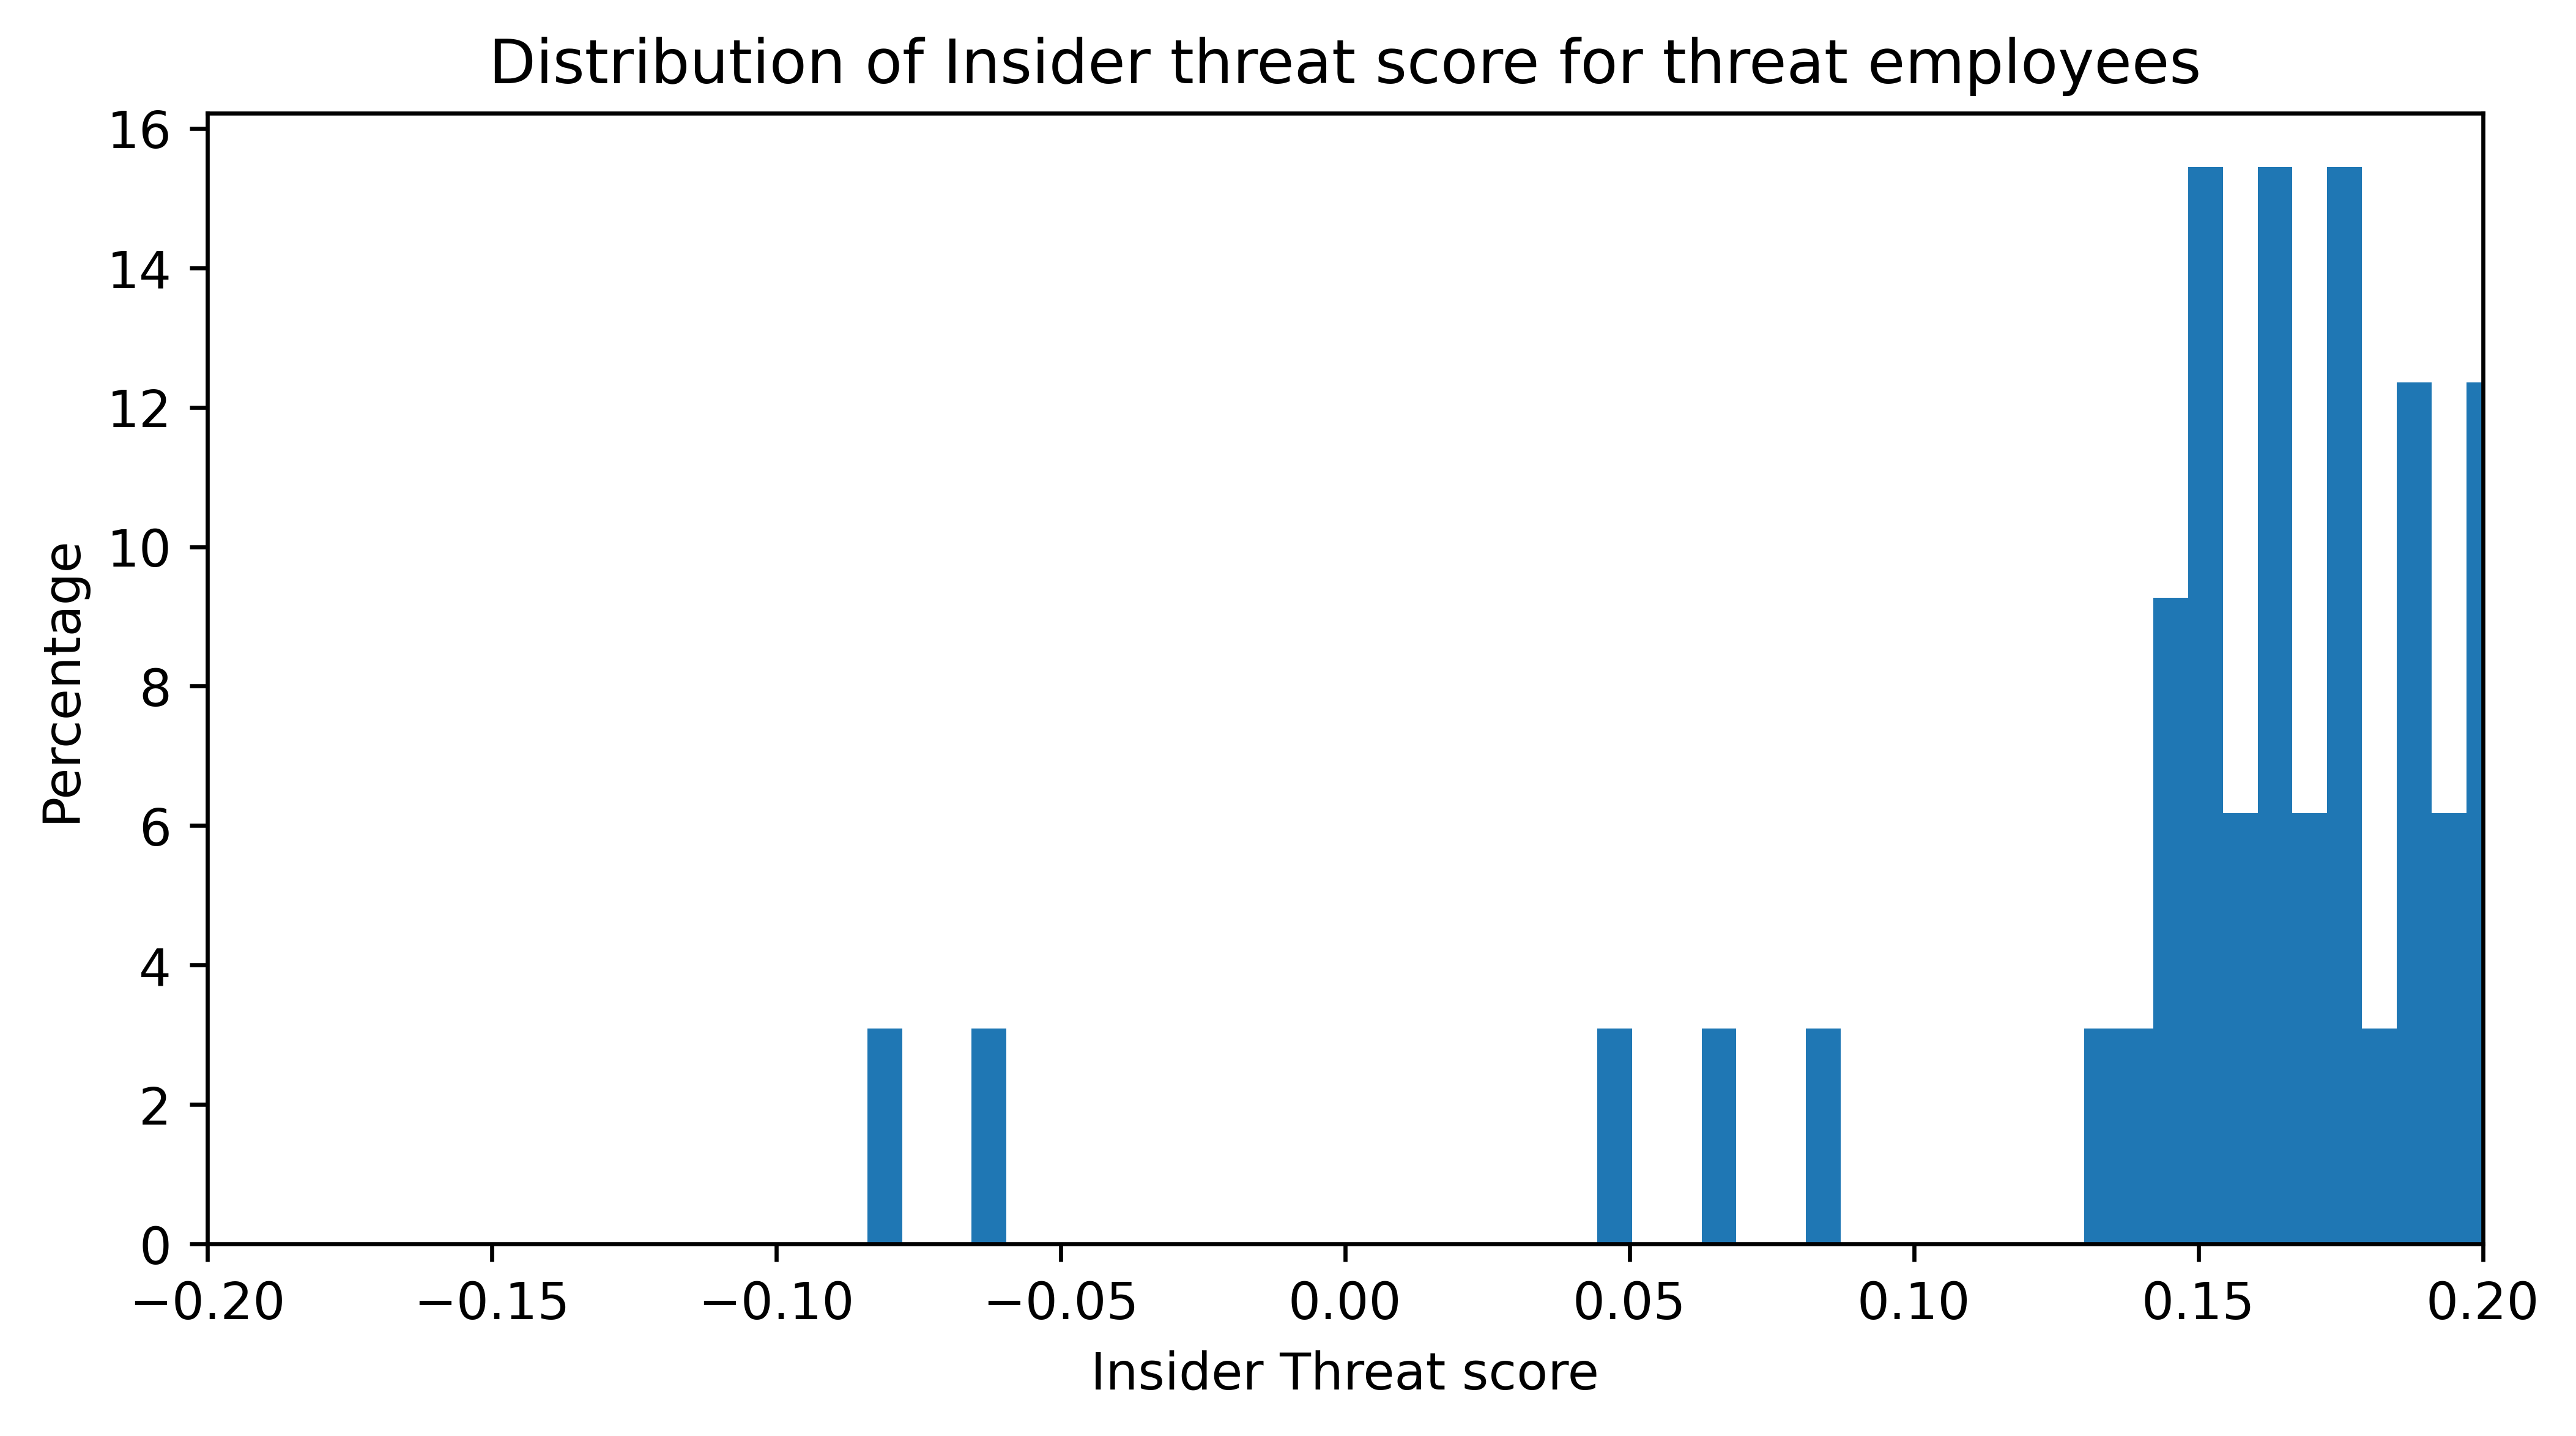

In [63]:
#Plotting for normal employee behaviours (score)
anomaly_scores = isolation_train.decision_function(X_train_threat)

fig = plt.figure(figsize=(8, 4), dpi=600, facecolor="w", edgecolor="k")
normal = plt.hist(anomaly_scores, 50, density=True)

plt.xlim((-0.2, 0.2))
plt.xlabel("Insider Threat score")
plt.ylabel("Percentage")
plt.title("Distribution of Insider threat score for threat employees")

In [65]:
#declaring cutt-off score on the training data
cutoff = 0.5

In [67]:
from collections import Counter

cutoff_score = isolation_train.decision_function(X_train_reshaped)
print(Counter(y_train[cutoff > cutoff_score]))

Counter({0.0: 697, 1.0: 53})


In [69]:
#declaring cutt-off score on the testing data
cutoff_score = isolation_train.decision_function(X_test_reshaped)
print(Counter(y_test[cutoff > cutoff_score]))


Counter({0.0: 233, 1.0: 17})


In [99]:
#models accuracy
#declaring various model scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report

#models evaluation matrix
# Predict the test set
y_pred_test = isolation_train.predict(X_test_reshaped)

# Convert the prediction to 0 and 1 (normal and threat)
# In IsolationForest, -1 means anomaly and 1 means normal
y_pred_test = np.where(y_pred_test == -1, 1, 0)
accuracy = accuracy_score(y_test, y_pred_test)
print(accuracy)

0.9


In [87]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print(conf_matrix)

[[225   8]
 [ 17   0]]


Text(50.72222222222221, 0.5, 'True Labels')

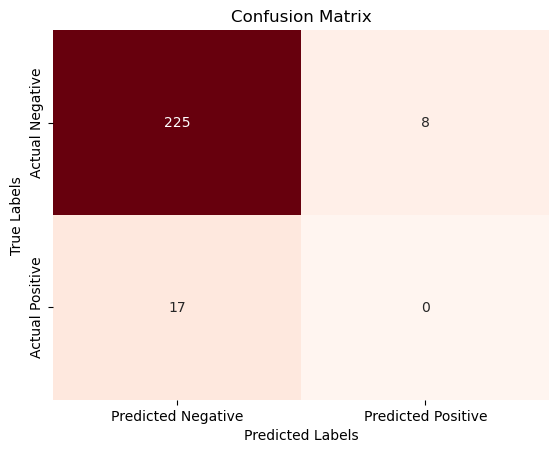

In [91]:
import seaborn as sns
#plotting confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [93]:
#ROC -AUC
roc_auc = roc_auc_score(y_test, y_pred_test)
print(roc_auc)

0.48283261802575106


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


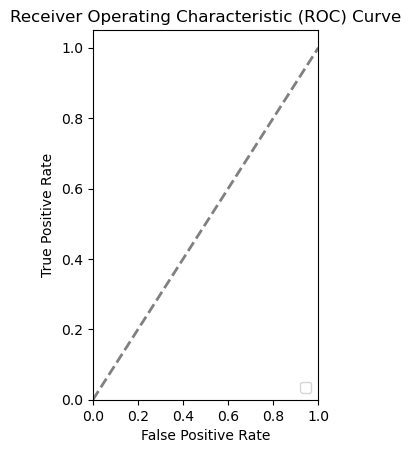

In [95]:
# Plotting ROC Curve
plt.subplot(1, 2, 2)
plt.plot(color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

In [89]:
#classification Report
class_report = classification_report(y_test, y_pred_test)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       233
         1.0       0.00      0.00      0.00        17

    accuracy                           0.90       250
   macro avg       0.46      0.48      0.47       250
weighted avg       0.87      0.90      0.88       250

